In [1]:
from pyscipopt import Model, quicksum
import numpy as np
from itertools import product, combinations
import json

In [2]:
#Importing constant variables
with open('./input_variables.json', 'r') as file:
    input_variables = json.load(file)

# print(input_variables["Qm"])

In [3]:
def instanSacy(n_customers, n_vehicles, max_demand, max_distance):
    No = set(np.arange(1,n_customers+1)) #Set of customers
    N = No | {0} #Customers + departure depot
    F = {"F1", "F2"} #Set of charging stations
    NF = No | F #Customers + charging stations
    G = N | F #Customers + departure depot + charging stations
    NP = No | {"P"} #Customers + arriving depot
    GP = NF | {"P"} #Customers + charging stations + Arriving depot 
    Gtotal = G | GP
    
    A = [(i,j) for i in G for j in GP if i!=j] #Set of arcs between the nodes
    # A = [(i,j) for i,j in product(Gtotal,Gtotal) if i!=j] #Set of arcs between the nodes
    
    demand = {i: 0 if i not in No else 100 for i in Gtotal} #Demand per customer
    # demand = {i: 0 if i not in No else int(np.random.randint(100, max_demand, 1)[0]) for i in Gtotal} #Demand per customer

    M = list(np.arange(1,n_vehicles+1)) #Set of vehicles

    load_capacity = {m:input_variables["Qm"] for m in M} #Load_capacity per vehicle
    
    '''Time cost as a function of distance and avg. speed'''
    distance =  {(i,j):(0 if (i,j) == (0,"P") else int(np.random.randint(50, max_distance, 25)[0])) for i,j in A}
    # time_cost = {(i,j):(distance[i,j] / input_variables["Avg_V"]) for i,j in A} #Travel time cost per arc
    time_cost = {(i,j):round((distance[i,j] / input_variables["Avg_V"]),2) for i,j in A} #Travel time cost per arc
    
    battery_capacity = input_variables["Battery_capacity_Wh"]
    battery_threshold = 35000 #Wh

    '''Energy cost as a function of Energy Consumption per Km'''
    EV_avg_energy_consumption = (290) #in W font:'https://ev-database.org/cheatsheet/energy-consumption-electric-car'
    CE_avg_energy_consumption = (0.16) #Liters/km font:'https://www.smmt.co.uk/wp-content/uploads/sites/2/Heavy-CV-Fuel-Consumption-Fact-Sheet.pdf'
    EV_energy_cost = {(i,j):20000 for (i,j) in A} #Energy cost per arc
    # EV_energy_cost = {(i,j):(EV_avg_energy_consumption*distance[i,j]) for (i,j) in A} #Energy cost per arc
    CE_energy_cost = {(i,j):(CE_avg_energy_consumption*distance[i,j]) for i,j in A} #Fuel cost per arc
    
    return No, N, F, NF, G, A, M, demand,load_capacity, battery_capacity, time_cost, distance, EV_energy_cost, CE_energy_cost, GP, Gtotal, NP, battery_threshold

In [4]:
def sacystation(No, N, F, NF, G, A, M, demand,load_capacity, battery_capacity, time_cost, distance, EV_energy_cost, CE_energy_cost, GP, Gtotal,NP,battery_threshold):
    """transp -- model for solving the transportation problem
    Parameters:
        No - set of customers
        N - customers + depot
        F - set of charging stations
        G - N + F
        A - set of arcs (i,j)
        M - set of vehicles
        energy_cost[i,j] - energy transportation cost on arc (i,j)
        demand[i] - demand of customer i
        load_capacity[m] - capacity of vehicle m
        time_cost - Travel time per arc(i,j)

    ==================================
    Problems: Sending m to a charging station
    """
    
    model = Model("sacystation")

    #Binary decision variable
    x = {}
    for (i,j,m) in [(i,j,m) for (i,j) in A for m in M]:
        x[i,j,m] = model.addVar(vtype="B", name=f"x{(i,j,m)}")
        
    #Load Variable
    l = {}
    for (i,j,m) in [(i,j,m) for (i,j) in A for m in M]:
        l[i,j,m] = model.addVar(vtype="C", lb=0, ub=load_capacity[m], name=f"l{(i,j,m)}")
    
    #Remaining Battery Variable
    y = {}
    for (i,m) in [(i,m) for i in Gtotal for m in M]:
        y[i,m] = model.addVar(vtype="C", lb=0, ub=battery_capacity, name=f"y[{i},{m}]")

    #Checking battery threshold
    low_battery = {}
    for (i,m) in [(i,m) for i in No for m in M]:
        low_battery[i,m] = model.addVar(vtype="B", name=f"low_battery[{i},{m}]")

    #Charge amount Variable
    v = {}
    for (i, m) in [(i, m) for i in (F | {0}) for m in M]:
        v[i, m] = model.addVar(vtype="C", lb=0, ub=battery_capacity, name=f"v[{i},{m}]")
        

    """
    Restrições Estruturais
    """
    '''
    Routing constraints
    1.Vehicles m must start their journey on the depot {0} and end it at the parking {P}
    2.Vehicles m must leave the depot, either to go to the parking lot or to serve N>=0 customers
    3.If vehicle m arrives at a customer or charging station it must leave it 
    4.Each customer can be visited only once 
    '''
    '''
    Each customer is visited only once
    '''
    for i in No:
        model.addCons(quicksum(x[i,j,m] for j in GP if (i,j) in A for m in M) == 1, name=f'customer_visiting[{i},{j},{m}]')
        # model.addCons(quicksum(x[i,j,m] for j in GP if i!=j for m in M) == 1, name=f'customer_visiting[{i},{j},{m}]')
    # for j in No:
    #     model.addCons(quicksum(x[i,j,m] for i in G if i!=j for m in M ) == 1, name=f'customer_visiting[{i},{j},{m}]')
    
    '''
    Triyng to get rid of subtours
    '''
    # for m in M:
    #     for S in range(2, len(No)):
    #         for subset in combinations(NF, S):
    #             model.addCons(quicksum(x[i, j, m] for i in subset for j in GP if i != j and j not in subset) == 1)

    '''
    Tour connectivity
    Flow constraint
    '''                
    for m in M:
        for j in NF:
            model.addCons(
                quicksum(x[i,j,m] for i in G if i!=j)
            -   quicksum(x[j,i,m] for i in GP if i!=j)
            == (1 if i == 0 else 0)
            ,name=f'tour_connectivity[{i},{j},{m}]'
            )
    
    '''
    Vehicles tours
    '''
    # if (len(No) - len(M)) < 0:
    if len(No) < len(M):
        for j in No:
            model.addCons(quicksum(x[0, j, m] for m in M) == 1, "num_vehicles_leaving_depot")
    else:
        for m in M:
            model.addCons(quicksum(x[0, j, m] for j in No) == 1, "num_vehicles_leaving_depot")

    '''
    Each charging stations is visited at most once // doubts here
    '''
    for i in F:
        model.addCons(quicksum(x[i,j,m] for j in NP if i!=j for m in M) <= 1, name=f'charging_visiting[{i},{j},{m}]')                     
 
    '''
    Enforces that the vehicle starts from the depot and go to the parking
    after the tour
    '''  
    for m in M:
        model.addCons(quicksum(x[0,j,m] for j in GP ) ==
                      quicksum(x[i,"P",m] for i in G), name=f'depot_to_depot[{m}]')
                     
    '''
    Time limit constraint
    '''
    for m in M:
        model.addCons(quicksum(time_cost[i,j]*x[i,j,m] for (i,j) in A) <= 8, name=f'timeLimit[{m}]')
                
    '''
    Demand constraints
    '''        
    '''
    Demand Satisfaction
    ''' 
    for i in GP:
        model.addCons((
            quicksum(l[j,i,m]*x[j,i,m] for j in G if (j,i) in A for m in M) -
            quicksum(l[i,k,m]*x[i,k,m] for k in GP if (i,k) in A for m in M))
            == demand[i], name=f'demand_satisfaction[{i}]'
            )    
    # for i in GP:
    #     model.addCons((
    #         quicksum(l[j,i,m]*x[j,i,m] for j in G if i!=j for m in M) -
    #         quicksum(l[i,k,m]*x[i,k,m] for k in GP if i!=k for m in M))
    #         == demand[i], name=f'demand_satisfaction[{i}]'
    #         )    
    
    '''
    Initialize Load at Departure
    '''
    for m in M:
        for j in No:
            model.addCons(l[0, j, m] == quicksum(demand[j] * x[i, j, m] for i,j in A),     name=f'init_load_departure[{0},{j},{m}]')
        
    '''
    Vehicle Load Capacity
    ''' 
    for m in M:
        for (i,j) in A:
        # for i in G:
        #     for j in GP:
        #         if i!=j:
                    model.addCons(demand[j] * x[i,j,m] <= l[i,j,m],     name=f'load_capacity[{i},{j},{m}')     
                    model.addCons(l[i,j,m] * x[i,j,m] <= (load_capacity[m] - demand[i])*x[i,j,m]  , name=f'load_capacity[{i},{j},{m}')

    """
    Battery Constraints
    """
    '''
    Battery capacity
    '''
    for m in M:
        for i in Gtotal:
            model.addCons(y[i,m] >= 0)
            model.addCons(y[i,m] <= battery_capacity)
    '''
    Initial charge at depot
    '''
    for m in M:
            model.addCons(v[0,m] == (input_variables["ICp"] * battery_capacity)
                        ,name=f'depot_vim_charge[{m}]')
            model.addCons(y[0,m] == v[0,m]
                        ,name=f'depot_charge[{m}]')

    '''
    Positive values for energy levels when leaving Depot
    '''
    for j in GP:
        for m in M:
            model.addCons(y[j,m] <= y[0,m], name=f'positive_energy_level[{j}]')
        
    '''
    Low Battery Indicator 
    '''
    for m in M:
        for j in G:
            for i in No:
                if j!=i:
                    model.addCons(y[i, m] <= battery_threshold + 100000 * (1 - low_battery[i, m])
                                  ,name=f"less_than_threshold[{i},{m}]")
                    model.addCons(y[i, m] >= (battery_threshold - 100000 * low_battery[i, m])*x[j,i,m]
                                  ,name=f"more_than_threshold[{i},{m}]")

    '''
    Battery Satisfaction
    '''
    for m in M:
        for i in N:
            for j in GP:
                if i!=j:
                    model.addCons((y[i,m] - y[j,m])*x[i,j,m] == EV_energy_cost[i,j]*x[i,j,m]
                                  ,name=f'battery_satisfaction[{i},{m}]')
        
    '''
    Battery Satisfaction at Charging Stations
    '''
    for m in M:
        for i in F:
            for j in NP:
                if i!=j:
                    model.addCons(((v[i,m] + y[i,m]) - y[j,m]) * x[i,j,m] == (EV_energy_cost[i,j])*x[i,j,m]
                                  ,name=f'battery_satisfaction[{i},{m}]')                    

    '''
    Force the car to go to a charging station if the battery is low
    '''
    # for m in M:
    #     for i in No:
    #         for j in F:
    #             model.addCons(x[i, j, m] >= low_battery[i, m])
    
    '''Force car to continue the journey with battery is above threshold'''
    # for m in M:
    #     for i in No:
    #         for j in GP:
    #             if i!=j:
    #                 model.addCons(x[i, j, m] >= 1 - low_battery[i, m])

    '''
    Maximum recharge at charging stations
    '''
    for m in M:
        for j in NF:
            for i in F:
                if i!=j:
                    # model.addCons(v[i,m] + y[i,m] >= 0, name=f'min_recharge[{i},{m}]')
                    model.addCons((v[i,m] + y[i,m]) * x[j,i,m] == (0.8 * battery_capacity) * x[j,i,m]
                                ,name=f'max_recharge[{i},{m}]')
    
    
    # Objective - ONLY TRAVEL TIME and Station Charging
    travel_time_cost = quicksum(input_variables["Ctt"]*time_cost[i,j]*x[i,j,m] for (i,j) in A for m in M)
    station_charging_cost = quicksum(input_variables['HPstation_charge_cost'] * v[i,m] for i in F for m in M)
    
    model.setObjective(travel_time_cost + station_charging_cost, "minimize")

    model.optimize()

    model.data = x
    
    return model, station_charging_cost, y, l, v, low_battery


In [5]:
if __name__ == "__main__":
    No, N, F, NF, G, A, M, demand,load_capacity, battery_capacity, time_cost, distance, EV_energy_cost, CE_energy_cost, GP, Gtotal, NP, battery_threshold = instanSacy(10,2,200,100)
    
    model, station_charging_cost, y, l, v, low_battery = sacystation(No, N, F, NF, G, A, M, demand,load_capacity, battery_capacity, time_cost, distance, EV_energy_cost, CE_energy_cost, GP, Gtotal, NP, battery_threshold) 
       
    model.optimize()
    
    # EPS = 1.e-6  # a small tolerance
    x = model.data  # model.data contains the decision variables

    if model.getStatus() == "optimal":
        print("Optimal value:", model.getObjVal())
    else:
        print("Problem could not be solved to optimality")      
    
    sol = {}
    for (i, j, m) in x:
        if model.getVal(x[i, j, m]) > 0.5:
            sol.update({f"x({i}, {j}, {m})":model.getVal(x[i, j, m])})
    #     # else:
    #     #     print(f"x[{i}, {j}, {m}] = 0")
    


In [ ]:
#DEBUGGING
# total_distance = sum(distance[i, j] for i, j, m in [(i, j, m) for i, j in A for m in M] if model.getVal(x[i, j, m]) > 0.5)
# print("Total distance traveled:", total_distance)

time_costij = {}
demandi = {}
lijm = {}
EV_costs = {}
yim = {}
vim = {}
low_batteryim = {}

for i, j, m in [(i, j, m) for i, j in A for m in M]: 
    if model.getVal(x[i, j, m]) > 0.5:
        time_costij.update({str((i,j)):time_cost[i,j]})
        demandi.update({str(i):demand[i]})
        lijm.update({str((i,j,m)):model.getVal(l[i,j,m])})
        EV_costs.update({str((i,j)):EV_energy_cost[i,j]})

#YIM        
for i, m in [(i, m) for i in Gtotal for m in M]:
    if model.getVal(y[i, m]) > 0.5: 
        yim.update({str((i,m)):model.getVal(y[i,m])})
#VIM
for i, m in [(i, m) for i in (F | {0}) for m in M]:
    if model.getVal(v[i, m]) > 0: 
        vim.update({str((i,m)):model.getVal(v[i,m])})
#LOW_BATTERY
for i, m in [(i, m) for i in No for m in M]:
    if model.getVal(low_battery[i, m]) > 0: 
        low_batteryim.update({str((i,m)):model.getVal(low_battery[i,m])})

debug = {
    "Sols":sol,
    # "timeij": time_costij,
    # "demandi": demandi,
    # "lijm":lijm,
    "energy_costs": EV_costs,
    "yim": yim,
    "low_battery": low_batteryim,
    "vim": vim
}
file_path = "./debug.json"
with open(file_path, "w") as json_file:
    json.dump(debug, json_file, indent=4)
print(f"Input variables have been written to {file_path}") 

Input variables have been written to ./debug.json


In [ ]:
model.writeProblem(r"D:\DAY2DAY\MESTRADO\Codes\SCIP\LPs\problem.lp")
# model.freeProb()

wrote problem to file D:\DAY2DAY\MESTRADO\Codes\SCIP\LPs\problem.lp


In [ ]:
# try: # plot the result using networkx and matplotlib
#          import networkx as NX
#          import matplotlib.pyplot as P
#          P.clf()
#          G = NX.Graph()
  
#          other = [j for j in y if j not in facilities]
#          customers = ["c%s"%i for i in d]
#          G.add_nodes_from(facilities)
#          G.add_nodes_from(other)
#          G.add_nodes_from(customers)
#          for (i,j) in edges:
#              G.add_edge("c%s"%i,j)
  
#          position = NX.drawing.layout.spring_layout(G)
#          NX.draw(G,position,node_color="y",nodelist=facilities)
#          NX.draw(G,position,node_color="g",nodelist=other)
#          NX.draw(G,position,node_color="b",nodelist=customers)
#          P.show()
# except ImportError:
#     print("install 'networkx' and 'matplotlib' for plotting")

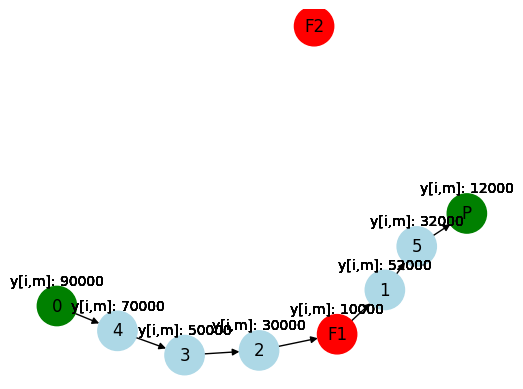

In [ ]:
import networkx as NX
import matplotlib.pyplot as P

try:
    # Initialize the graph
    G = NX.DiGraph()

    # Add nodes for customers, depots, and charging stations
    for node in No:  # Assuming No is the set of customer nodes
        G.add_node(node, node_color='lightblue')
    G.add_node(0, node_color='green')  # Depot
    for station in F:  # Assuming F is the set of charging stations
        G.add_node(station, node_color='red')
    G.add_node("P", node_color='green')  # Arriving Depot

    # Add edges based on the model's solution
    for m in M:  # Iterate over vehicles
        for (i, j) in A:  # Iterate over arcs
            if model.getVal(x[i, j, m]) > 0.5:  # Check if arc is used
                G.add_edge(i, j)
    
    # Plot the graph
    P.clf()
    position = NX.spring_layout(G)  # Position nodes using Fruchterman-Reingold force-directed algorithm
    #Battery values in each node
    
    for node in G.nodes():
        for m in M:
            for i in Gtotal:
                if model.getVal(y[i, m]) > 0.5:
                    y_value = f'y[i,m]: {model.getVal(y[i, m]):.0f}'
                    P.annotate(f'{y_value}', xy=position[i], textcoords='offset points', xytext=(0,15), ha='center')


    NX.draw(G, position, with_labels=True, node_size=800, node_color=[G.nodes[node]['node_color'] for node in G.nodes])
    P.show()

except ImportError:
    print("Install 'networkx' and 'matplotlib' for plotting")



In [ ]:
model.freeProb()